In [5]:
"""
Fisher test at each tissue
    Background: All STRs
    Forground: eSTRs 
"""

# Libraries
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import os
from collections import defaultdict
import pandas as pd
import scipy.stats as ss
import seaborn.apionly as sns

SHORTEN = {
    "Artery-Aorta":"Artery.A"     ,
    "Artery-Tibial": "Artery.T",
    "Adipose-Subcutaneous": "Adipose.S",    
    "Adipose-Visceral(Omentum)":"Adipose.V",
    "Brain-Caudate(basalganglia)":"Caudate"   , 
    "Brain-Cerebellum":"Cerebellum",
    "Cells-Transformedfibroblasts": "Fibroblast",
    "Esophagus-Mucosa": "Mucosa",
    "Esophagus-Muscularis":"Muscularis",
    "Heart-LeftVentricle":"Ventricule",
    "Lung": "Lung",
    "Muscle-Skeletal": "Muscle",
    "Nerve-Tibial":"Nerve",
    "Skin-NotSunExposed(Suprapubic)": "SkinUnexposed",
    "Skin-SunExposed(Lowerleg)":"SkinLeg",
    "Thyroid":"Thyroid",
    "WholeBlood": "Blood",
}
TISSUES = [item for item in list(SHORTEN.keys()) if item != "permuted"]

regr='/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/LR_SummaryTest_Table.tsv'
feat='/storage/szfeupe/Runs/GTEx_estr/FEATURES/Allgencodefeatures_table'
motif='/storage/resources/dbase/human/hg19/hg19.hipstr_reference_withmotif.bed'



In [6]:
F=[] 
#open files
R = pd.read_csv(regr, sep='\t')  ; X = R[["gene","chrom","str.start","E.tissues"]]

O=defaultdict(list)
Mapdata = {}
Mset=[]
for tis in TISSUES:
    field ='eSTR.'+SHORTEN[tis]
 
    # Focus on estrs and motifs
    E =R.loc[R['eSTR.'+SHORTEN[tis]]==1]
    T=list(set(list(E['motif'])))
    C=[list(E['motif']).count(x) for x in T]
    EM = [[x,list(E['motif']).count(x)] for x in T]
    frequent_motifs=[x for x in EM if x[1]>10]
    #print(frequent_motifs)
    #######
    data = G[["gene","chrom", "str.start","motif",'eSTR.'+SHORTEN[tis]]]#,"best.score","best.tissue","INTRON"]]
    data_e = data.loc[data[field]>0]
    AC = ['AAAC', 'AAAAC','AAAAAC', 'AAC', 'AC']
    AT = ['AT', 'AAT', 'AAAT', 'AAAAT', 'AAAAAT']
    data_eat = data_e.loc[data_e['motif'].isin(AT)]
    data_eac = data_e.loc[data_e['motif'].isin(AC)]
    data_at = data.loc[data['motif'].isin(AT)]
    data_ac = data.loc[data['motif'].isin(AC)]
    #print(data_e.shape, data_at.shape, data_ac.shape)
    CTT_at=[[data_eat.shape[0],data_e.shape[0]- data_eat.shape[0]],[data_at.shape[0]-data_eat.shape[0], data.shape[0]-data_e.shape[0]-(data_at.shape[0]-data_eat.shape[0])]]
    CTT_ac=[[data_eac.shape[0],data_e.shape[0]- data_eac.shape[0]],[data_ac.shape[0]-data_eac.shape[0], data.shape[0]-data_e.shape[0]-(data_ac.shape[0]-data_eac.shape[0])]]
    od_ac, pvc = ss.fisher_exact([CTT_ac[0], CTT_ac[1]])
    od_at, pvt = ss.fisher_exact([CTT_at[0], CTT_at[1]])
#    print('\nNOTE: n=1,2,3,4,5 \n P (Finding an eSTR with  a given motif by chance)== P()\n')
#    print ("P (A(n)T-rich motif) ~~ ",pvt*100,"% with OR=", od_at)
#    print ("P (A(n)C-rich motif) ~~ ",pvc*100,"% with OR=", od_ac)

    #frequent_motifs
    Motifs = list(set(list(data_e['motif'])))
    Mo_counts=[list(data['motif']).count(x) for x in Motifs]
    Estr = data_e.shape[0]
    Str = data.shape[0]
    FMotifs = [x[0] for x in frequent_motifs]
    sig_motifs=[]
    All = []
    #print('\n We calculated at eSTRs sites the probability \n P (For finding an eSTR with a given motif by chance)== P()\n')
    for M in Motifs:
        data_eM = data_e.loc[data_e['motif']==M]
        data_M = data.loc[data['motif']==M]
        Mestrs = data_eM.shape[0]
        Mstrs = data_M.shape[0]
        CTT = [[Mestrs, Estr - Mestrs] , [Mstrs-Mestrs , Str-Estr -(Mstrs - Mestrs)]] #contengency
        oddsratio, pv = ss.fisher_exact([CTT[0], CTT[1]])
    ####print ("P (", M, ")    ~~   ",pv*100,"%     with    OR=", oddsratio)
        All.append([M,list(data_e['motif']).count(M),-np.log10(pv),oddsratio])
        O[M].append(oddsratio)
        if pv<=0.05:
            sig_motifs.append([M,pv*100,oddsratio])
    
    p=Estr/data.shape[0]
    count_uniq_mo = sorted(list(set(Mo_counts)))
    ordered_All = []
    for u in count_uniq_mo:
        ordered_All=ordered_All + [x for x in All if x[1]==u]
    count_uniq_mo = sorted(list(set([x[2] for x in All])))
    ordered_All = []
    for u in count_uniq_mo:
        ordered_All=ordered_All + [x for x in All if x[2]==u]
    Mapdata[tis] = All  # [ motif - motifcount_estrs - log(pval) - OR]
    Mset=[s for s in Motifs if s not in Mset] + Mset



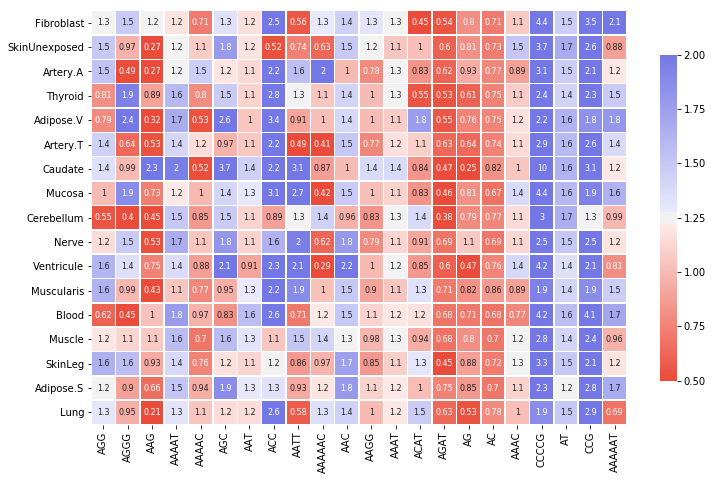

In [7]:
Mapdata
Mset = []
for o in O.keys():      # O has all the motifs and occurence in tissues
    if len(O[o])>=17:
        Mset.append(o)

pdata = np.zeros((len(TISSUES), len(Mset)))

for i in range(len(TISSUES)):
    T = TISSUES[i]
    for j in range(len(Mset)):
        m=Mset[j]
        val = [s[3] for s in  Mapdata[T] if s[0]==m ]
        if val==[]:
            pdata[i][j] =0
        else:
            pdata[i][j] =val[0]
#    print(pdata[i])    #
    #
#plot
fig, ax = plt.subplots(figsize=(12, 12))
cmap = sns.diverging_palette(15, 265, s=80, l=55, n=9, as_cmap=True)    
sns.heatmap(pdata, cmap=cmap, annot=True, annot_kws={"size": 8},
            vmin=0.5, vmax=2, square=True, ax=ax, linewidths=0.5, cbar_kws={"shrink": 0.5},
           yticklabels=[SHORTEN[t] for t in TISSUES], 
           xticklabels=Mset);
ax.invert_xaxis();
plt.show()


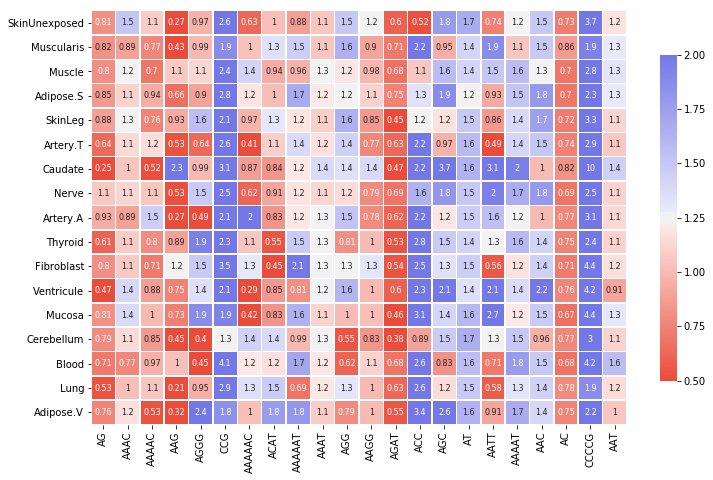

In [38]:
Mapdata
Mset = []
for o in O.keys():      # O has all the motifs and occurence in tissues
    if len(O[o])>=17:
        Mset.append(o)

pdata = np.zeros((len(TISSUES), len(Mset)))

for i in range(len(TISSUES)):
    T = TISSUES[i]
    for j in range(len(Mset)):
        m=Mset[j]
        val = [s[3] for s in  Mapdata[T] if s[0]==m ]
        if val==[]:
            pdata[i][j] =0
        else:
            pdata[i][j] =val[0]
#    print(pdata[i])    #
    #
#plot
fig, ax = plt.subplots(figsize=(12, 12))
cmap = sns.diverging_palette(15, 265, s=80, l=55, n=9, as_cmap=True)    
sns.heatmap(pdata, cmap=cmap, annot=True, annot_kws={"size": 8},
            vmin=0.5, vmax=2, square=True, ax=ax, linewidths=0.5, cbar_kws={"shrink": 0.5},
           yticklabels=[SHORTEN[t] for t in TISSUES], 
           xticklabels=Mset);
ax.invert_xaxis();
plt.show()
